In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam



In [ ]:

data_path = '/content/drive/MyDrive/thesis all/thesis dataset'
img_size = (299, 299)
batch_size = 32

all_image_files = []
all_labels = []

for class_folder in os.listdir(data_path):
    class_path = os.path.join(data_path, class_folder)
    if os.path.isdir(class_path):
        for image_file in os.listdir(class_path):
            if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                all_image_files.append(os.path.join(class_path, image_file))
                all_labels.append(class_folder)

train_files, test_files, train_labels, test_labels = train_test_split(
    all_image_files, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

train_files, val_files, train_labels, val_labels = train_test_split(
    train_files, train_labels, test_size=0.1, random_state=29, stratify=train_labels
)

datagen = ImageDataGenerator(rescale=1./255)

train_data_generator = datagen.flow_from_dataframe(
    pd.DataFrame({'filename': train_files, 'class': train_labels}),
    x_col='filename',
    y_col='class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_data_generator = datagen.flow_from_dataframe(
    pd.DataFrame({'filename': val_files, 'class': val_labels}),
    x_col='filename',
    y_col='class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_data_generator = datagen.flow_from_dataframe(
    pd.DataFrame({'filename': test_files, 'class': test_labels}),
    x_col='filename',
    y_col='class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 712 validated image filenames belonging to 2 classes.
Found 80 validated image filenames belonging to 2 classes.
Found 199 validated image filenames belonging to 2 classes.


In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_data_generator,
    epochs=10,
    validation_data=val_data_generator
)

test_loss, test_accuracy = model.evaluate(test_data_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


87910968/87910968 [==============================] - 5s 0us/step
Epoch 1/10
23/23 [==============================] - 584s 23s/step - loss: 0.2606 - accuracy: 0.8806 - val_loss: 0.1487 - val_accuracy: 0.9375
Epoch 2/10
23/23 [==============================] - 170s 7s/step - loss: 0.0548 - accuracy: 0.9789 - val_loss: 0.0677 - val_accuracy: 0.9875
Epoch 3/10
23/23 [==============================] - 172s 7s/step - loss: 0.0254 - accuracy: 0.9916 - val_loss: 0.0184 - val_accuracy: 1.0000
Epoch 4/10
23/23 [==============================] - 172s 8s/step - loss: 0.0168 - accuracy: 0.9930 - val_loss: 0.0881 - val_accuracy: 0.9625
Epoch 5/10
23/23 [==============================] - 170s 7s/step - loss: 0.0203 - accuracy: 0.9930 - val_loss: 0.0553 - val_accuracy: 0.9875
Epoch 6/10
23/23 [==============================] - 162s 7s/step - loss: 0.0226 - accuracy: 0.9916 - val_loss: 0.0263 - val_accuracy: 0.9875
Epoch 7/10
23/23 [==============================] - 164s 7s/step - loss: 0.0154 - accura

7/7 [==============================] - 40s 6s/step


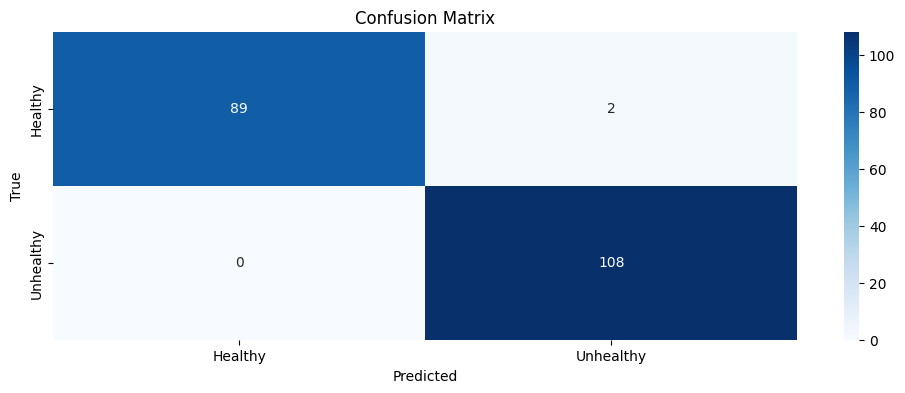


Classification Report:
              precision    recall  f1-score   support

     Healthy       1.00      0.98      0.99        91
   Unhealthy       0.98      1.00      0.99       108

    accuracy                           0.99       199
   macro avg       0.99      0.99      0.99       199
weighted avg       0.99      0.99      0.99       199



In [ ]:
import seaborn as sns
plt.figure(figsize=(12, 4))
predictions = model.predict(test_data_generator)
y_true = test_data_generator.classes
y_pred = predictions.argmax(axis=-1)
cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Unhealthy'], yticklabels=['Healthy', 'Unhealthy'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Healthy', 'Unhealthy']))


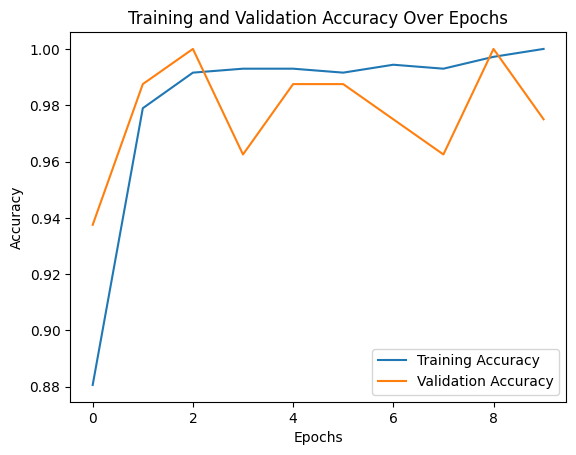

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

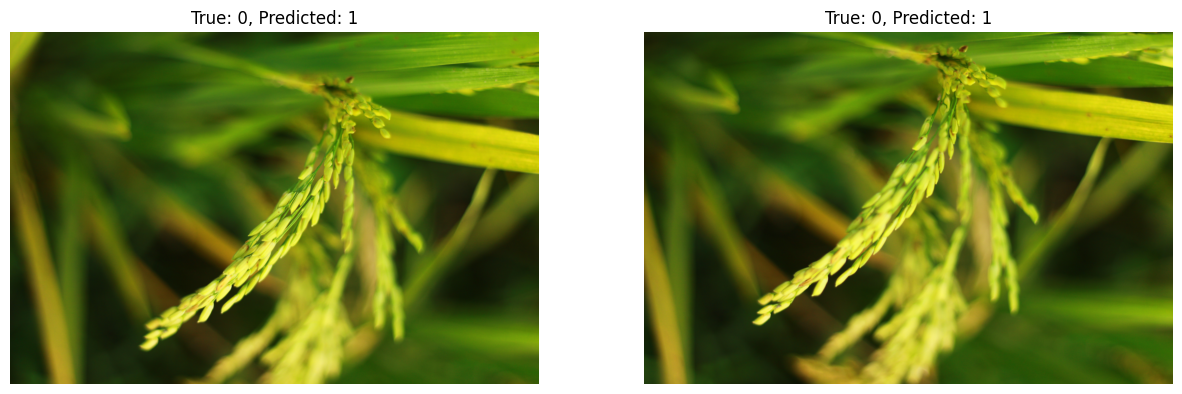

In [ ]:
y_true = test_data_generator.classes
y_pred = predictions.argmax(axis=-1)

misclassified_indices = np.where(y_true != y_pred)[0]

plt.figure(figsize=(15, 5))
for i, index in enumerate(misclassified_indices):
    img_path = test_data_generator.filepaths[index]
    img = plt.imread(img_path)
    plt.subplot(1, len(misclassified_indices), i + 1)
    plt.imshow(img)
    plt.title(f'True: {test_data_generator.classes[index]}, Predicted: {y_pred[index]}')
    plt.axis('off')

plt.show()

USING PREPROCESSING

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import LabelEncoder


In [ ]:

data_path = '/content/drive/MyDrive/thesis all/thesis dataset'
img_size = (299, 299)
batch_size = 32

all_image_files = []
all_labels = []

for class_folder in os.listdir(data_path):
    class_path = os.path.join(data_path, class_folder)
    if os.path.isdir(class_path):
        for image_file in os.listdir(class_path):
            if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                all_image_files.append(os.path.join(class_path, image_file))
                all_labels.append(class_folder)

train_files, test_files, train_labels, test_labels = train_test_split(
    all_image_files, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

train_files, val_files, train_labels, val_labels = train_test_split(
    train_files, train_labels, test_size=0.1, random_state=29, stratify=train_labels
)

label_encoder = LabelEncoder()
train_labels_indices = label_encoder.fit_transform(train_labels)

class_weights = compute_sample_weight('balanced', train_labels_indices)
class_weight_dict = {class_index: weight for class_index, weight in zip(np.unique(train_labels_indices), class_weights)}

print("Class Weights:", class_weight_dict)

datagen = ImageDataGenerator(rescale=1./255)

train_data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_data_generator = train_data_generator.flow_from_dataframe(
    pd.DataFrame({'filename': train_files, 'class': train_labels}),
    x_col='filename',
    y_col='class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    class_indices=dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))),
    shuffle=True
)

val_data_generator = datagen.flow_from_dataframe(
    pd.DataFrame({'filename': val_files, 'class': val_labels}),
    x_col='filename',
    y_col='class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    class_indices=dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))),
    shuffle=False
)
test_data_generator = datagen.flow_from_dataframe(
    pd.DataFrame({'filename': test_files, 'class': test_labels}),
    x_col='filename',
    y_col='class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    class_indices=dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))),
    shuffle=False
)

Class Weights: {0: 0.9198966408268734, 1: 0.9198966408268734}
Found 712 validated image filenames belonging to 2 classes.
Found 80 validated image filenames belonging to 2 classes.
Found 199 validated image filenames belonging to 2 classes.


In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_data_generator,
    epochs=15,
    validation_data=val_data_generator,
    class_weight=class_weight_dict
)

test_loss, test_accuracy = model.evaluate(test_data_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/15
23/23 [==============================] - 240s 9s/step - loss: 0.3976 - accuracy: 0.7978 - val_loss: 0.4827 - val_accuracy: 0.7375
Epoch 2/15
23/23 [==============================] - 184s 8s/step - loss: 0.1343 - accuracy: 0.9494 - val_loss: 0.2759 - val_accuracy: 0.8875
Epoch 3/15
23/23 [==============================] - 185s 8s/step - loss: 0.0780 - accuracy: 0.9663 - val_loss: 0.0721 - val_accuracy: 0.9625
Epoch 4/15
23/23 [==============================] - 187s 8s/step - loss: 0.0502 - accuracy: 0.9789 - val_loss: 0.0117 - val_accuracy: 1.0000
Epoch 5/15
23/23 [==============================] - 202s 9s/step - loss: 0.0401 - accuracy: 0.9888 - val_loss: 0.0503 - val_accuracy: 0.9875
Epoch 6/15
23/23 [==============================] - 179s 8s/step - loss: 0.0461 - accuracy: 0.9860 - val_loss: 0.0803 - val_accuracy: 0.9750
Epoch 7/15
23/23 [==============================] - 186s 8s/step - loss: 0.0284 - accuracy: 0.9902 - val_loss: 0.0174 - val_accuracy: 0.9875
Epoch 8/15
23

In [ ]:
model.save('/content/drive/MyDrive/thesis all.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


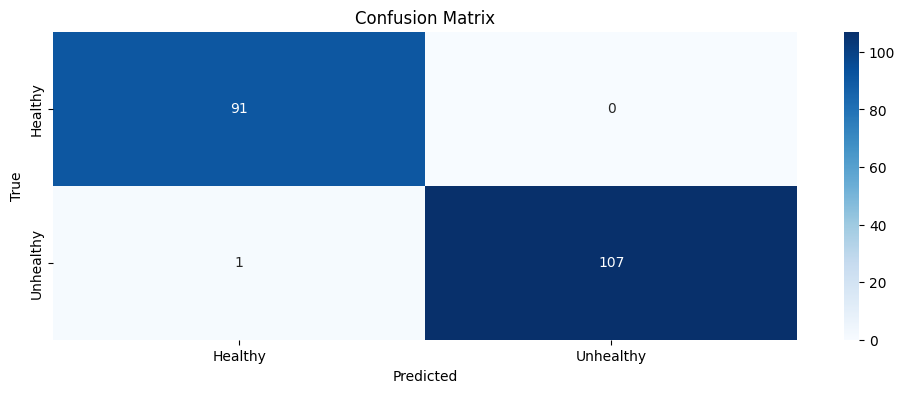


Classification Report:
              precision    recall  f1-score   support

     Healthy       0.99      1.00      0.99        91
   Unhealthy       1.00      0.99      1.00       108

    accuracy                           0.99       199
   macro avg       0.99      1.00      0.99       199
weighted avg       1.00      0.99      0.99       199



In [ ]:
import seaborn as sns
plt.figure(figsize=(12, 4))
cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Unhealthy'], yticklabels=['Healthy', 'Unhealthy'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Healthy', 'Unhealthy']))


7/7 [==============================] - 50s 7s/step


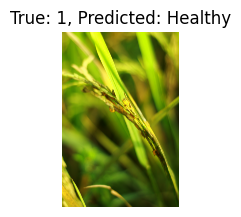

In [ ]:

predictions = model.predict(test_data_generator)

threshold = 0.5

y_true = test_data_generator.classes
y_pred = (predictions[:, 1] > threshold).astype(int)

misclassified_indices = np.where(y_true != y_pred)[0]

plt.figure(figsize=(15, 5))
for i, index in enumerate(misclassified_indices[:min(10, len(misclassified_indices))], 1):
    img_path = test_data_generator.filepaths[index]
    img = plt.imread(img_path)
    plt.subplot(2, 5, i)
    plt.imshow(img)
    plt.title(f'True: {test_data_generator.classes[index]}, Predicted: {label_encoder.classes_[y_pred[index]]}')
    plt.axis('off')

plt.show()



In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

model = load_model('/content/drive/MyDrive/thesis all.h5')

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(299, 299))
    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    img_preprocessed = img_batch / 255.0
    return img_preprocessed

new_image_path = '/content/drive/MyDrive/thesis all/healthy/new 2.jpg'

img_preprocessed = preprocess_image(new_image_path)

predictions = model.predict(img_preprocessed)

predicted_class_index = np.argmax(predictions[0])
predicted_class_label = label_encoder.classes_[predicted_class_index]

print("Predicted Class:", predicted_class_label)


1/1 [==============================] - 2s 2s/step
Predicted Class: Healthy
